In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = "/content/drive/MyDrive/PlantVillage"

In [4]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/drive/MyDrive/PlantVillage')

In [5]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('/content/drive/MyDrive/PlantVillage/Pepper__bell___healthy/3306b49b-e3b3-4450-8609-ae44ab2b6593___bell-pepper-plant-61726.jpg')]

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1


In [7]:
early_blight = list(data_dir.glob('Potato___Early_blight/*'))
early_blight[:5]

[PosixPath('/content/drive/MyDrive/PlantVillage/Potato___Early_blight/0c4f6f72-c7a2-42e1-9671-41ab3bf37fe7___RS_Early.B 6752.JPG'),
 PosixPath('/content/drive/MyDrive/PlantVillage/Potato___Early_blight/094fbf4c-da00-4037-82af-03e712d8db47___RS_Early.B 6908.JPG'),
 PosixPath('/content/drive/MyDrive/PlantVillage/Potato___Early_blight/0a8a68ee-f587-4dea-beec-79d02e7d3fa4___RS_Early.B 8461.JPG'),
 PosixPath('/content/drive/MyDrive/PlantVillage/Potato___Early_blight/0d2325ff-4e3e-44bf-9614-e5ad6c23fc16___RS_Early.B 6797.JPG'),
 PosixPath('/content/drive/MyDrive/PlantVillage/Potato___Early_blight/060fd5a7-1606-4a59-895b-604c90d6b414___RS_Early.B 7205.JPG')]

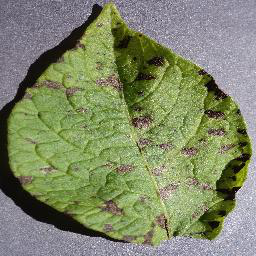

In [8]:
PIL.Image.open(str(early_blight[1]))

In [9]:
flowers_images_dict = {
    'potato_early_blight': list(data_dir.glob('Potato___Early_blight/*')),
    'potato_late_blight': list(data_dir.glob('Potato___Late_blight/*')),
    'potato_healthy': list(data_dir.glob('Potato___healthy/*')),
}

In [10]:
flowers_labels_dict = {
    'potato_early_blight': 0,
    'potato_late_blight': 1,
    'potato_healthy': 2,
}

In [11]:
flowers_images_dict['potato_healthy'][:5]

[PosixPath('/content/drive/MyDrive/PlantVillage/Potato___healthy/c85bacb0-e5e8-4127-a0b0-a7342f2cab5f___RS_HL 5406.JPG'),
 PosixPath('/content/drive/MyDrive/PlantVillage/Potato___healthy/4bbccfb6-5720-4c80-9b37-0c3ed8999c9f___RS_HL 1791.JPG'),
 PosixPath('/content/drive/MyDrive/PlantVillage/Potato___healthy/d325e580-5faa-4aea-927d-2700f52cc343___RS_HL 1872.JPG'),
 PosixPath('/content/drive/MyDrive/PlantVillage/Potato___healthy/111cd9d8-4d27-4225-be9e-d29b21cf56b9___RS_HL 5419.JPG'),
 PosixPath('/content/drive/MyDrive/PlantVillage/Potato___healthy/b35b9f8b-daca-4d12-a5be-defe68d0acc5___RS_HL 1903.JPG')]

In [12]:
img = cv2.imread(str(flowers_images_dict['potato_healthy'][0]))

In [13]:
img.shape

(256, 256, 3)

In [14]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224, 224)) 
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [15]:
X = np.array(X)
y = np.array(y)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [17]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [18]:
import tensorflow_hub as hub
feature_extractor_model = "https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"

In [19]:
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [20]:
num_of_flowers = 3

model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(224, 224, 3)),  # <-- specify input shape here
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23561152  
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23,567,299
Trainable params: 6,147
Non-trainable params: 23,561,152
_________________________________________________________________


In [21]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
51/51 [==============================] - 347s 7s/step - loss: 0.3685 - acc: 0.8679
Epoch 2/5
51/51 [==============================] - 329s 6s/step - loss: 0.1201 - acc: 0.9701
Epoch 3/5
51/51 [==============================] - 336s 7s/step - loss: 0.0804 - acc: 0.9813
Epoch 4/5
51/51 [==============================] - 329s 6s/step - loss: 0.0598 - acc: 0.9900
Epoch 5/5
51/51 [==============================] - 326s 6s/step - loss: 0.0483 - acc: 0.9938


In [22]:
model.evaluate(X_test_scaled,y_test)

17/17 [==============================] - 115s 7s/step - loss: 0.0721 - acc: 0.9813


[0.07211805135011673, 0.9813084006309509]

In [25]:
def predict(model, image):
    img_array = cv2.resize(image, (224, 224))
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = round(100 * (np.max(predictions[0])), 2)

    if predicted_class == 0:
        class_name = 'early_blight'
    elif predicted_class == 1:
        class_name = 'late_blight'
    else:
        class_name = 'healthy'
        
    return class_name, confidence


In [26]:
model.save("/content/drive/MyDrive/PlantVillage/super2.h5")